# Exploratory Data Analysis - Box Office Datasets


## Business Understanding
Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies.
<br>
You are charged with:
- Exploring what types of films are currently doing the best at the box office
- Translating the findings into actionable insights that the head of Microsoft's new movie studio can use to help decide what type of films to create


## Data Understanding
In the folder **`Data`** are movie Datasets:
<br>

| File Format | Source Info  |Contains|
|------|------|------|
|bom.movie_gross.csv |Box Office Mojo|Gross Information of Movies|
|rt.movie_info.tsv|Rotten Tomatoes|Movie Information|
|rt.reviews.tsv|Rotten Tomatoes|Movie Reviews  Information|
|tmdb.movies.csv|TheMovieDB|Movie Popularity Information|
|tn.movie_budgets.csv|The Numbers|Movies budget Information|
|im.db|IMDB|Movie Information as shown in the DataBase schema below|

Because it was collected from various locations, the different files have different formats as shown in the table above. Some are compressed CSV (comma-separated values) or TSV (tab-separated values) files that can be opened using spreadsheet software or pd.read_csv, while the data from IMDB is located in a SQLite database.

>_Below is the Database Schema of the IMDB database_
![movie_data_erd.jpeg](movie_data_erd.jpeg)


## Importing the required libraries for the EDA process

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

# 1.[IMDB Dataset](https://www.imdb.com/)
***
## a.Data Preparation 
### Unzipping the `.zip` files
In the cells below we import the necessary libraries required for unzipping our data to access the SQLite DB

In [2]:
#importing the necessary libraries for unzipping
import glob
import zipfile

In [3]:
#Unzipping the .zip files for the IMDB
files = glob.glob('zippedData/*.zip')
files

['zippedData\\im.db.zip']

In [4]:
for file in files:
    print('Unzipping:',file)

    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('data/raw')

Unzipping: zippedData\im.db.zip


## b.Creating a connection with the im database

In [5]:
#Importing the SQLite library and creating a database connection
import sqlite3
conn=sqlite3.connect('data/raw/im.db')

### Most films belong to which Genre??

In [6]:
q1='''
SELECT genres, COUNT(genres) as totalMovies
FROM movie_basics
GROUP BY genres
ORDER BY totalMovies DESC
LIMIT 15;'''
genres_top=pd.read_sql(q1,conn)
genres_top

,genres,totalMovies
0,Documentary,32185
1,Drama,21486
2,Comedy,9177
3,Horror,4372
4,"Comedy,Drama",3519
5,Thriller,3046
6,Action,2219
7,"Biography,Documentary",2115
8,"Drama,Romance",2079
9,"Comedy,Drama,Romance",1558


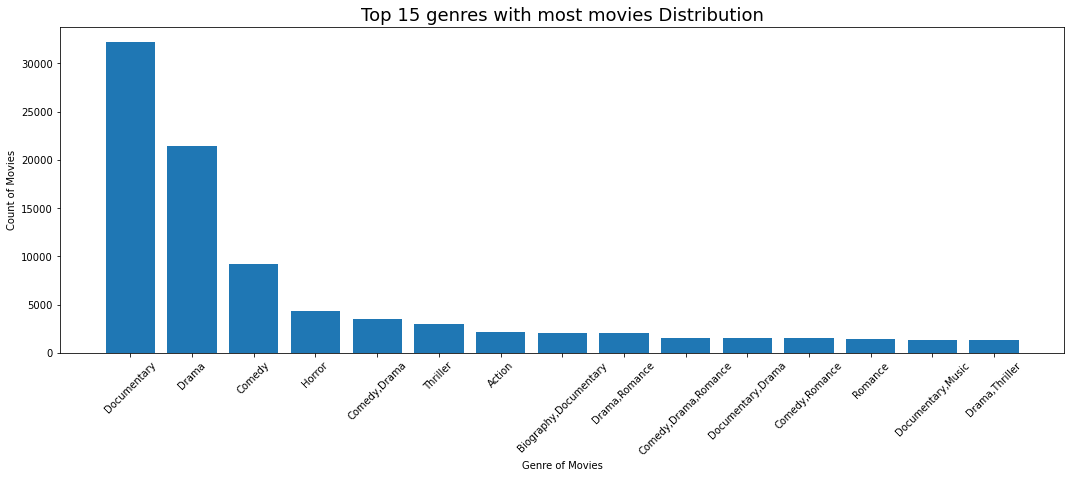

In [7]:
fig, ax=plt.subplots(figsize=(18,6))
x=genres_top['genres']
y=genres_top['totalMovies']

plt.xticks(rotation=45)
ax.set_xlabel("Genre of Movies")
ax.set_ylabel("Count of Movies")
ax.set_title("Top 15 genres with most movies Distribution",fontsize=18)
ax.bar(x,y);

In [8]:
q2='''
SELECT *
FROM ;'''
rating_genre=pd.read_sql(q1,conn)
rating_genre

,genres,totalMovies
0,Documentary,32185
1,Drama,21486
2,Comedy,9177
3,Horror,4372
4,"Comedy,Drama",3519
5,Thriller,3046
6,Action,2219
7,"Biography,Documentary",2115
8,"Drama,Romance",2079
9,"Comedy,Drama,Romance",1558


# 2.[Box Office Mojo Dataset](https://www.boxofficemojo.com/)
***


## Loading and Inspecting the dataset

In [9]:
# Load the CSV files as a DataFrame
# Url path for our Datasets
grossBom_path='zippedData/bom.movie_gross.csv.gz'

#Coverting the zipped CSV files into a DataFrame
grossBom=pd.read_csv(grossBom_path, compression='gzip')
grossBom.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


In [10]:
#feature selection
grossBom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [11]:
grossBom.shape

(3387, 5)

### Checking missing values
Based on our data we have significant missing values on the **foreign_gross** and a few missing values on **studio** and **domestic_gross** series respectively.<br>
We also need to convert our **foreign_gross** series from __object__ to __int64__

In [12]:
#checking for duplicates
grossBom.duplicated().any()

False

In [13]:
grossBom.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [14]:
#converting foreign_gross into int type
try:
    grossBom['foreign_gross']=grossBom['foreign_gross'].astype(float)
except Exception as error:
    print(error)

could not convert string to float: '1,131.6'


In [15]:
# Removing all special characters in the foreign_gross series 
grossBom['foreign_gross'].replace(',', '', inplace=True, regex=True)

#converting the foreign_gross series to float
grossBom['foreign_gross']=grossBom['foreign_gross'].astype(float)
grossBom['foreign_gross'].dtype

dtype('float64')

In [16]:
missing_domestic=round((grossBom['domestic_gross'].isna().sum()/len(grossBom))*100,2)
missing_foreign=round((grossBom['foreign_gross'].isna().sum()/len(grossBom))*100,2)
missing_studio=round((grossBom['studio'].isna().sum()/len(grossBom))*100,2)

print(f'Missing domestic_gross values percentage: {missing_domestic}% ')
print(f'Missing foreign_gross values percentage: {missing_foreign}%')
print(f'Missing studio names percentage: {missing_studio}%')

Missing domestic_gross values percentage: 0.83% 
Missing foreign_gross values percentage: 39.86%
Missing studio names percentage: 0.15%


### Dealing with missing values
Since the **missing studio names** and **domestic_gross** constitute 0.15% and 0.83% of our dataset, we'll have to drop the missing rows. 
<br>
The **missing foreign_gross** constitute 39.86% of our dataset. The **best approach would be to replace the missing/NAN values** by Zero

In [17]:
#Dropping rows with missing values
grossBom.dropna(subset=['studio','domestic_gross'],axis=0,inplace=True)

#Replacing missing foreign_gross values with zero
grossBom['foreign_gross'].fillna(value=0, axis=0,inplace=True)
grossBom.shape

(3356, 5)

In [18]:
#Rechecking our Dataset to see if it has missing values
grossBom.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

In [19]:
#Creating Total gross i.e domestic+foreign
grossBom['worldwide_gross']=grossBom.apply(lambda x: 
                               (x.domestic_gross + x.foreign_gross), 
                               axis=1)
grossBom.head()

,title,studio,domestic_gross,foreign_gross,year,worldwide_gross
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08
3,Inception,WB,292600000.0,535700000.0,2010,8.283000e+08
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,7.526000e+08


### What studios generate the highest revenue worldwide?

Top 10 studios with the highest movie count released

In [20]:
grossBom[['studio']].value_counts()[:10]

studio
IFC       166
Uni.      147
WB        140
Fox       136
Magn.     136
SPC       123
Sony      109
BV        106
LGF       102
Par.      101
dtype: int64

Top 20 Studios with the highest Revenue generated worldwide

In [21]:
#studios with the highest number of movies
studio_20=grossBom.groupby(by=['studio']).aggregate({'worldwide_gross':'mean'}).sort_values(by='worldwide_gross',ascending=False)
studio_20=studio_20[:20]

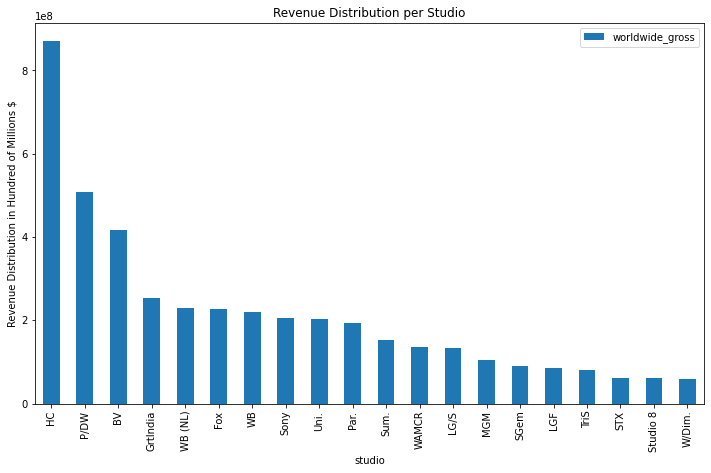

In [22]:
studio_20.plot(kind='bar',figsize=(12,7))
plt.title('Revenue Distribution per Studio')
plt.ylabel('Revenue Distribution in Hundred of Millions $');

# 3.[The MovieDB Dataset](https://www.themoviedb.org/)
***

## Loading and Inspecting the dataset
It looks like this CSV came with an index column, resulting in an extra column called `Unnamed: 0` which we have to get rid off

In [23]:
# Url path for our Datasets
tmdb_path='zippedData/tmdb.movies.csv.gz'
tmdb=pd.read_csv(tmdb_path,index_col=0,compression='gzip')
tmdb.head(2)

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610


In [24]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


In [25]:
tmdb.columns

Index(['genre_ids', 'id', 'original_language', 'original_title', 'popularity',
       'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')

### Dealing with Missing values

It seems that we have No missing values

In [26]:
#convert release_date data type to date
try:
    tmdb['release_date']=pd.to_datetime(tmdb['release_date'])
    tmdb['release_month']= tmdb['release_date'].dt.month_name()
    tmdb['release_year']= tmdb['release_date'].dt.year
except Exception as error:
    print(error)

In [27]:
tmdb.describe()

,id,popularity,vote_average,vote_count,release_year
count,26517.000000,26517.000000,26517.000000,26517.000000,26517.000000
mean,295050.153260,3.130912,5.991281,194.224837,2013.953162
std,153661.615648,4.355229,1.852946,960.961095,3.544641
min,27.000000,0.600000,0.000000,1.000000,1930.000000
25%,157851.000000,0.600000,5.000000,2.000000,2012.000000
50%,309581.000000,1.374000,6.000000,5.000000,2014.000000
75%,419542.000000,3.694000,7.000000,28.000000,2016.000000
max,608444.000000,80.773000,10.000000,22186.000000,2020.000000


In [28]:
#Remove datasets exceeding the past decade
tmdb = tmdb[tmdb['release_year'] >=2010]

In [29]:
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_month,release_year
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,November,2010
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,March,2010
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,May,2010
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,July,2010
5,"[12, 14, 10751]",32657,en,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,February,2010


In [30]:
#Mean and median of votes
tmdb['vote_average'].agg(['mean','median'])

mean      5.986117
median    6.000000
Name: vote_average, dtype: float64

In [31]:
#Top 10 Movie languages
tmdb['original_language'].value_counts().head(10)

en    23106
fr      505
es      455
ru      297
ja      251
de      233
zh      177
hi      172
it      122
pt       95
Name: original_language, dtype: int64

In [32]:
# Drop movies of different original languages to maintain English
tmdb= tmdb.loc[tmdb['original_language'] == 'en']

# Normalize the genre_ids series to have individual values i.e [12, 14, 10751]
tmdb['genre_ids'] = tmdb['genre_ids'].map(lambda x:eval(x))
tmdb = tmdb.explode('genre_ids')

In [33]:
# Drop rows with few vote counts
tmdb = tmdb[tmdb['vote_count'] >1000]
tmdb

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_month,release_year
0,12,12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,November,2010
0,14,12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,November,2010
0,10751,12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,November,2010
1,14,10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,March,2010
1,12,10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,March,2010
...,...,...,...,...,...,...,...,...,...,...,...
24128,18,301337,en,Downsizing,10.682,2017-12-22,Downsizing,5.1,1887,December,2017
24128,878,301337,en,Downsizing,10.682,2017-12-22,Downsizing,5.1,1887,December,2017
24169,16,339877,en,Loving Vincent,10.025,2017-09-22,Loving Vincent,8.2,1200,September,2017
24169,18,339877,en,Loving Vincent,10.025,2017-09-22,Loving Vincent,8.2,1200,September,2017


Replace the Genre_ids with the actual film category as shown in [The Movie Database Support](https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee)

In [34]:
# Replace the genre_ids with the actual category
tmdb['genre_ids'].replace(
    {12: "Adventure",
     10751:"Family " ,
     10752:"War",
     14: "Fantasy",
     9648 :"Mystery",
     16: "Animated",
     18: "Drama",
     27: "Horror",
     28: "Action",
     35: "Comedy",
     10749:'Romance',
     10770:"TV Movie",
     36: "History",
     37: "Western",
     53: "Thriller",
     80: "Crime",
     878: "Sci-fi"}, inplace=True)
tmdb['genre_ids'].value_counts()

Drama        434
Action       339
Comedy       312
Thriller     302
Adventure    274
Sci-fi       194
Fantasy      161
Romance      147
Crime        145
Horror       121
Family       120
Mystery      102
Animated      87
History       49
War           22
10402         17
Western       17
TV Movie       2
Name: genre_ids, dtype: int64

In [35]:
tmdb.describe()

,id,popularity,vote_average,vote_count,release_year
count,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000
mean,202226.751494,17.421555,6.625975,3872.446046,2014.321968
std,135677.591962,8.550687,0.727545,3235.195672,2.458021
min,189.000000,0.600000,4.100000,1001.000000,2010.000000
25%,72113.000000,11.981000,6.100000,1596.000000,2012.000000
50%,198277.000000,15.287000,6.600000,2715.000000,2015.000000
75%,321258.000000,20.129000,7.200000,4829.000000,2016.000000
max,569547.000000,80.773000,8.400000,22186.000000,2018.000000


In [36]:
tmdb.head(2)

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_month,release_year
0,Adventure,12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,November,2010
0,Fantasy,12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,November,2010


### What is the average Rating per Genre?

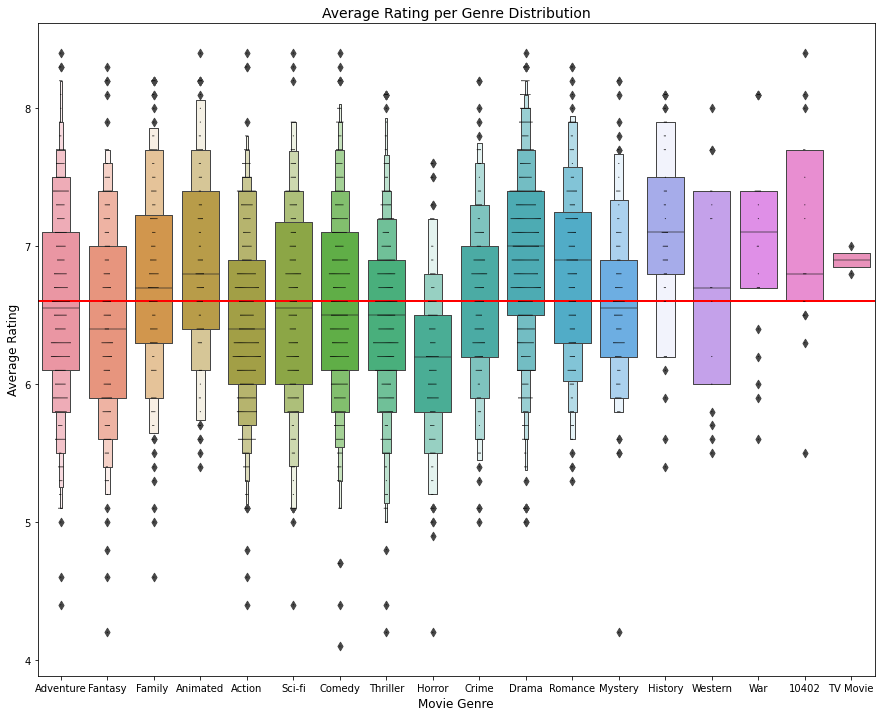

In [37]:
plt.figure(figsize=(15,12))

sns.boxenplot(data=tmdb, x='genre_ids', y='vote_average')
sns.swarmplot(data = tmdb,x ='genre_ids', y ='vote_average',color= 'black',size=1)
plt.title('Average Rating per Genre Distribution',fontsize=14)
plt.xlabel('Movie Genre',fontsize=12)
plt.axhline(y=6.6,linewidth=2,color='red')
plt.ylabel('Average Rating',fontsize=12);

### Summary
- This boxplot shows the correlation between the average ratings and differnt genres of movies
- Horror has the lowest median compared to the other genres
- History Genre has the highest median rating but consists of less vote_counts as compared to the rest
- Focus on genres with a better rating where the volume is larger i.e those that fall above the red line

# 4.[The Numbers Dataset ](https://www.the-numbers.com/)
***

### Loading and Inspecting the dataset

In [38]:
# Url path for our Datasets
tnBudget_path='zippedData/tn.movie_budgets.csv.gz'
tnBudget=pd.read_csv(tnBudget_path,compression='gzip')
tnBudget.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [39]:
tnBudget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


### Cleaning the Dataset
Based on the preview of the data we have no missing values but we have to remove special characters on production_budget,domestic_gross and worlwide_gross series

In [40]:
columns=['production_budget','domestic_gross','worldwide_gross']
for column in columns:
    # Removing ($ and ,) special characters in production_budget,domestic_gross and worldwide_gross
    tnBudget[column]=tnBudget[column].str.replace('[$,]', '')
    

tnBudget.head(2)   

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875


In [41]:
#converting the Numerical values to type int
columns=['production_budget','domestic_gross','worldwide_gross']
for column in columns:
    tnBudget[column]=tnBudget[column].astype(float)

In [42]:
#Converting release date to datetime dtype
tnBudget['release_date']=pd.to_datetime(tnBudget['release_date'], format= '%b %d, %Y')
#Creating a new month column
tnBudget['release_month']=tnBudget['release_date'].dt.month_name()
tnBudget['release_year']=tnBudget['release_date'].dt.year

In [43]:
tnBudget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
 6   release_month      5782 non-null   object        
 7   release_year       5782 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 361.5+ KB


In [44]:
# Checking Duplicates
tnBudget.duplicated().any()

False

In [45]:
tnBudget.describe()

,id,production_budget,domestic_gross,worldwide_gross,release_year
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03,5782.000000
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07,2003.967139
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08,12.724386
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00,1915.000000
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06,2000.000000
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07,2007.000000
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07,2012.000000
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09,2020.000000


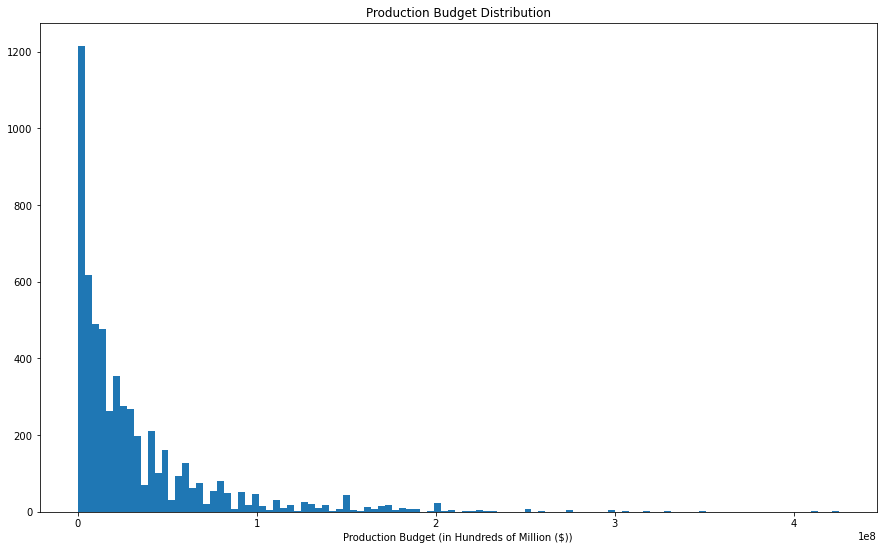

In [46]:
#Distribution of production_budget
plt.figure(figsize=(15,9))

plt.title('Production Budget Distribution')
plt.xlabel('Production Budget (in Hundreds of Million ($))')
plt.hist(tnBudget['production_budget'],bins='auto');

In [47]:
# Data is skewed so we divide the bins to ranks
bins=[0,17000000,45000000,np.inf]
rank=['Budget-friendly','Mid-range','Expensive']

tnBudget['production_tier'] = pd.cut(tnBudget['production_budget'], bins, labels=rank)

In [48]:
tnBudget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_month,release_year,production_tier
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,December,2009,Expensive
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,May,2011,Expensive
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,June,2019,Expensive
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,May,2015,Expensive
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,December,2017,Expensive


In [49]:
# Engineering Profit column i.e  domestic_gross - production_budget and worldwide_gross - production_budget
#domestic profit
tnBudget['domestic_ROI']=tnBudget.apply(lambda x: 
                               (x.domestic_gross-x.production_budget), axis=1)
# worldwide profit
tnBudget['worldwide_ROI']=tnBudget.apply(lambda x: 
                               (x.domestic_gross-x.production_budget), axis=1)

# worldwideROI%
tnBudget['ROI%']=tnBudget.apply(lambda x: 
                               (x.worldwide_ROI/x.production_budget)*100, axis=1)
# Profitability of the business
def condition(x):
    if x>=0:
        return "Profit"
    else:
        return 'Loss'
tnBudget['profit/loss']=tnBudget['worldwide_ROI'].apply(condition)

In [50]:
tnBudget.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_month,release_year,production_tier,domestic_ROI,worldwide_ROI,ROI%,profit/loss
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,December,2009,Expensive,335507625.0,335507625.0,78.942971,Profit
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,May,2011,Expensive,-169536125.0,-169536125.0,-41.289850,Loss


In [51]:
#Convert release year to int data type
tnBudget['release_year']=tnBudget['release_year'].astype(int)
tnBudget.describe()

,id,production_budget,domestic_gross,worldwide_gross,release_year,domestic_ROI,worldwide_ROI,ROI%
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03,5782.000000,5.782000e+03,5.782000e+03,5782.000000
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07,2003.967139,1.028557e+07,1.028557e+07,198.354021
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08,12.724386,4.992137e+07,4.992137e+07,2608.659060
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00,1915.000000,-3.072376e+08,-3.072376e+08,-100.000000
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06,2000.000000,-9.132757e+06,-9.132757e+06,-79.436711
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07,2007.000000,-3.487755e+05,-3.487755e+05,-12.167378
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07,2012.000000,1.778144e+07,1.778144e+07,105.814816
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09,2020.000000,6.306622e+08,6.306622e+08,179900.000000


#### Movies with the highest Returns on Investments
Return on Investments of different movie production tiers

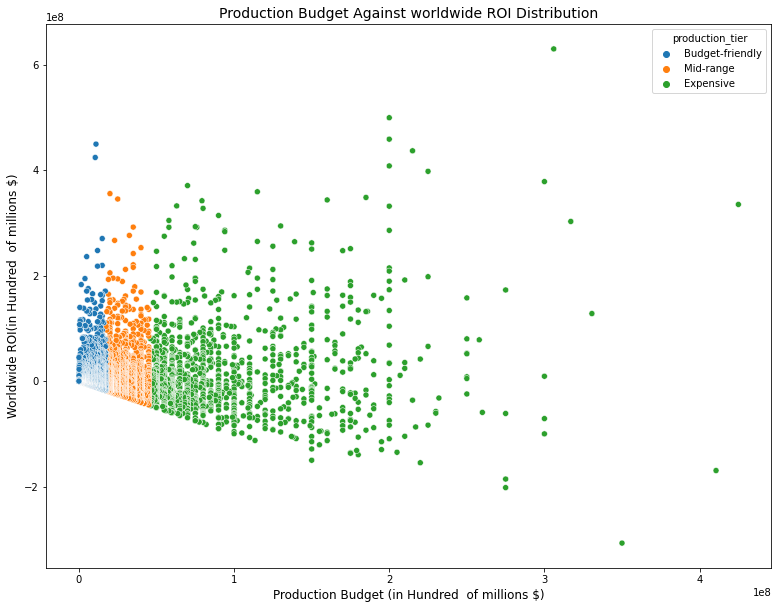

In [52]:
fig, ax = plt.subplots(figsize=(13,10))

sns.scatterplot(data=tnBudget, x='production_budget',y='worldwide_ROI',hue='production_tier')
ax.set_title('Production Budget Against worldwide ROI Distribution',fontsize=14)
ax.set_xlabel('Production Budget (in Hundred  of millions $)',fontsize=12)
ax.set_ylabel('Worldwide ROI(in Hundred  of millions $)',fontsize=12);

The Higher the production Budget the higher the ROI but also the margin of making loses increases exponetially

In [53]:
#movies with the highest profits worldwide
movies_hROI = tnBudget.sort_values(by=['worldwide_ROI'], ascending=False)
movies_hROI.reset_index(inplace=True)

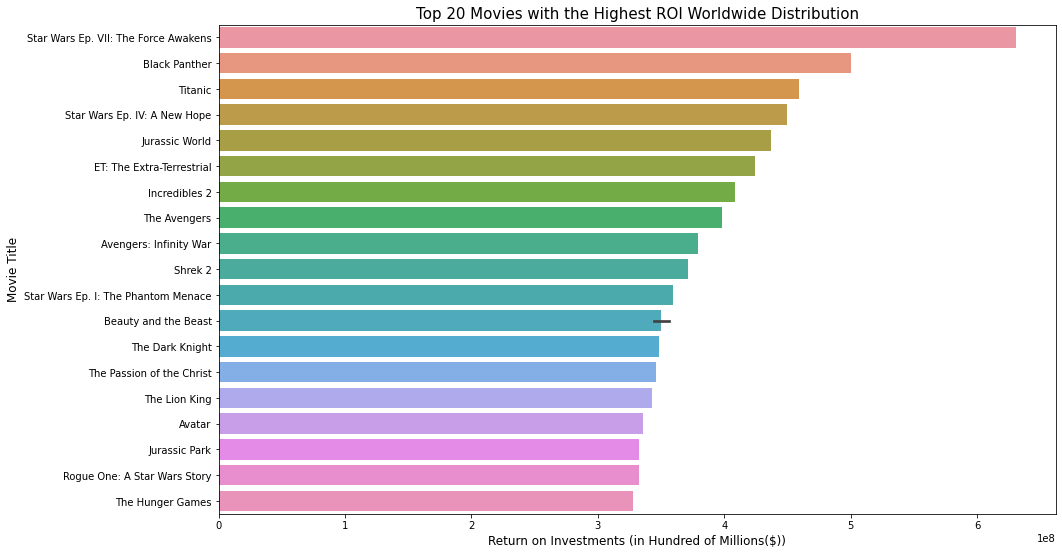

In [54]:
fig, ax = plt.subplots(figsize=(15,9))

title = movies_hROI['movie'][0:20]
ROI = movies_hROI['domestic_ROI'][0:20]

ax=sns.barplot(data=movies_hROI,x=ROI,y=title)

ax.set_title('Top 20 Movies with the Highest ROI Worldwide Distribution',fontsize=15)
ax.set_ylabel('Movie Title',fontsize=12)
ax.set_xlabel('Return on Investments (in Hundred of Millions($))',fontsize=12);

***
#### Identifying Relationships of various features on our dataset

In [55]:
tnBudget=tnBudget[(tnBudget['release_year']) >= 2010]

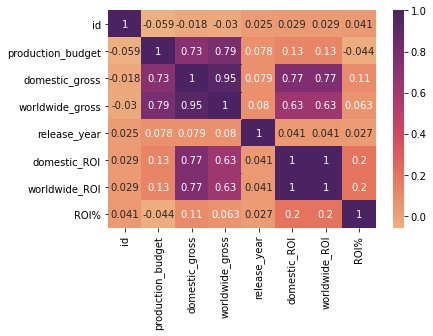

In [56]:
# Checking the Relationships of various features
fig, plt.plot(figsize=(15,5)) 

color=sns.color_palette('flare', as_cmap=True)
correlation=tnBudget.corr()
sns.heatmap(correlation, annot=True,cmap=color);

## Profit and Loss Analysis of Films Over the years

In [57]:
tnBudget.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_month,release_year,production_tier,domestic_ROI,worldwide_ROI,ROI%,profit/loss
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,May,2011,Expensive,-169536125.0,-169536125.0,-41.289850,Loss
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,June,2019,Expensive,-307237650.0,-307237650.0,-87.782186,Loss


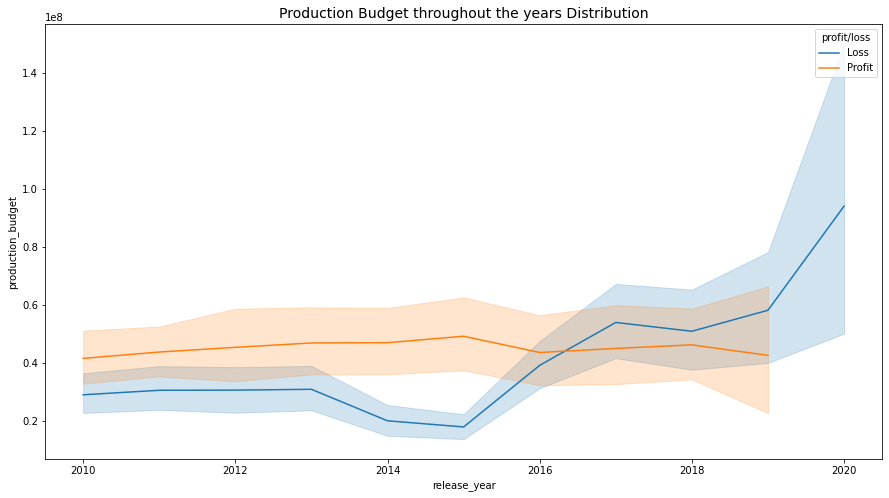

In [58]:
fig, ax=plt.subplots(figsize=(15,8))

ax.set_title('Production Budget throughout the years Distribution',fontsize=14)
sns.lineplot(data=tnBudget, x='release_year', y='production_budget',hue='profit/loss');

### Which is the most profitable/non-profitable month to release movies

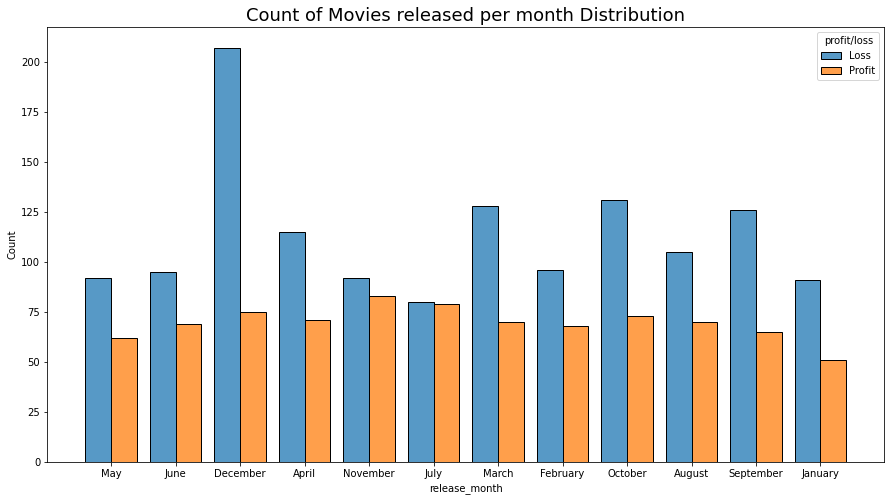

In [59]:
fig, ax=plt.subplots(figsize=(15,8))

ax.set_title('Count of Movies released per month Distribution',fontsize=18)
sns.histplot(data=tnBudget, x='release_month', hue='profit/loss', multiple='dodge', shrink=.8);

### Summary
The Numbers Summary:
- December is the most profitable time to release a movie as compared to the rest.
- Avoid Releasing Movies during November and July as there exists a 50/50 chance it might flop
- Since 2010 to 2016 most movies in the Box Office made profits
- Between 2017 to 2020  majority of the films made losses due to Unknown reasons pending futher analysis
***

# 5.[Rotten Tomatoes Dataset](https://www.rottentomatoes.com/)
***

### Loading and Inspecting the dataset

In [60]:
#Load the Rotten Tomatoes TSV files as a DataFrame
rt_movie_path='zippedData/rt.movie_info.tsv.gz'
rt_reviews_path='zippedData/rt.reviews.tsv.gz'

#converting all the zipped TSV files into a DataFrame
rt_movies=pd.read_csv(rt_movie_path,delimiter='\t',encoding='latin1',compression='gzip')
rt_reviews=pd.read_csv(rt_reviews_path,delimiter='\t',encoding='latin1',compression='gzip')

#Preview of the Rotten tomatoes movies dataset
rt_movies.head(2)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One


### Tip
Use the runtime, theater date, genre,rating, writer,director,Rating and box_office features

In [61]:
#Preview of the Rotten tomatoes reviews dataset
rt_reviews.head(2)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"


In [62]:
#Renaming our date to establish
rt_reviews.columns = rt_reviews.columns.str.replace('date', 'review_date')

In [63]:
rt_reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,review_date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [64]:
#Merge the two dataframes
#rt_merge=pd.merge(rt_movies, rt_reviews, on='id')
#rt_merge.head(2)

In [65]:
rt_reviews[rt_reviews.duplicated()]

,id,review,rating,fresh,critic,top_critic,publisher,review_date
8129,304,"Friends With Kids is a smart, witty and potty-...",NaN,fresh,NaN,0,Liverpool Echo,"June 29, 2012"
14575,581,NaN,4.5/5,fresh,NaN,0,Film Threat,"December 6, 2005"
26226,1055,NaN,4/5,fresh,NaN,0,Film Threat,"December 6, 2005"
35162,1368,NaN,2/5,rotten,NaN,0,Film Threat,"December 6, 2005"
35166,1368,NaN,2/5,rotten,NaN,0,Film Threat,"December 8, 2002"
40567,1535,NaN,2/5,rotten,NaN,0,Film Threat,"December 6, 2005"
42381,1598,"This tired, neutered action thriller won't cau...",2/5,rotten,NaN,0,Empire Magazine,"November 14, 2008"
49487,1843,NaN,0.5/5,rotten,NaN,0,Film Threat,"December 6, 2005"
49492,1843,NaN,0.5/5,rotten,NaN,0,Film Threat,"December 8, 2002"
